# EI balance in the CA3-CA1 feedforward network - tuned vs untuned weights

In [1]:
from brian2 import *
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/usr/local/lib/python2.7/dist-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


In [2]:
def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [3]:
def randomInput(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr

In [4]:
def gridPlot(inp):
    '''Plots neurons on a grid to show active cells'''
    gridOn=True
    edgeSqr = int(np.sqrt(len(inp)))
    activeNeurons = np.reshape(inp, (edgeSqr,edgeSqr))
    cmap = LinearSegmentedColormap.from_list('CA3_reds', [(0., 'white'), (1., (170/256., 0, 0))])
    cmap.set_bad(color='white')
    fig, ax = plt.subplots()
    heatmap = ax.pcolormesh(activeNeurons,cmap=cmap)
    
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_ticks(np.arange(0,edgeSqr), minor=True)
        axis.set(ticks=np.arange(0,edgeSqr,int(edgeSqr/5))+0.5, ticklabels=np.arange(0,edgeSqr,int(edgeSqr/5))) #Skipping square labels

    if gridOn:
        ax.grid(True, which='minor', axis='both', linestyle='--', alpha=0.1, color='k')
    ax.set_xlim((0,edgeSqr))
    ax.set_ylim((0,edgeSqr))

    ax.set_aspect(1)
    fig.set_figheight(2.)
    fig.set_figwidth(2.5)
    simpleaxis(ax,every=True,outward=False)

    plt.show()

In [5]:
def tuneSynapses(network):
    ''' Tune synapses with a Hebbian plasticity rule.'''
    

In [6]:
def calculateEI_imbalance(conductances, iterations):
    ''' Calculate the degree of error for this stimulation'''
    
    for j in range(iterations):
        
        ei_ratio = []
        ei_ratio.append(max(conductances[0].gi)/max(conductances[0].ge))
    ei_imbalance = (np.var(ei_ratio))
    plt.show()

In [7]:
def calculate_ei_delay(g_exc, g_inh):
    '''Returns the max conductance and delay'''
    return np.max(g_exc), np.flatnonzero(g_inh)[0] - np.flatnonzero(g_exc)[0]

In [8]:
def visualise_connectivity(S, source='Source', target='Target'):
    Ns = len(S.source)
    Nt = len(S.target)
#     figure(figsize=(10, 4))
    fig, ax = plt.subplots()
    ax.plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    ax.plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        ax.plot([0, 1], [i, j], '-k')
    ax.set_xticks([0, 1], [source, target])
    ax.set_ylabel('Neuron index')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-1, max(Ns, Nt))
    simpleaxis(ax,every=True)
    plt.show()

## Parameterizing the CA3-CA1 network

In [9]:
## Network parameters

## Connectivity
p_CA3_CA1 = 0.05
p_CA3_I = 0.2
p_I_CA1 = 0.2

N_CA3 = 100 # CA3
N_I = 20 # Interneurons
N_CA1 = 100 #CA1 cells

# Cell intrinsic Parameters

Cm = 100*pF
gl = 6.25*nS # This was initially 5e-5 siemens

# Reversal potentials
El = -65*mV # Was -60mV
Ee = 0*mV
Ei = -80*mV

minThreshold, maxThreshold = -60, -30
CA1_VT = np.linspace(minThreshold, maxThreshold, N_CA1 ) *mV

## Synaptic parameters

# Synaptic time constants

taue = 10 *ms
taui = 20 *ms
we = 10*nS  # excitatory synaptic weight
wi = 10*nS  # inhibitory synaptic weight, was -67 nS
del_CA3_CA1 = 2*ms
del_CA3_I = 2*ms
del_I_CA1 = 2*ms

# The model

### CA3
spiking_eqs = Equations('''
dv_/dt = (-v_+inp)/(20*ms) : 1
inp : 1
''')

### Interneurons
eqs_I = Equations('''
dv/dt = (gl*(El-v)+ge*(Ee-v))/Cm : volt
dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens
''')

### CA1
eqs_CA1 = Equations('''
dv/dt = (gl*(El-v)+ge*(Ee-v)+gi*(Ei-v))/Cm : volt
v_th : volt  # neuron-specific threshold
dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens
''')

## Simulation parameters

K = 10 # Number of neurons stimulated (based on fraction of area covered)
inp = randomInput(N=N_CA3,K=K)
active_indices = np.nonzero(inp)[0]

input_time = 1*ms
spike_times = K*[input_time]

runtime = 100 # milliseconds
waittime = 1000 # milliseconds

## Plasticity parameters
inhChange = 5*nS

### CA1 inh plasticity
inh_plasticity = 'w+=inhChange'

## Setting up model

In [10]:
Pe = SpikeGeneratorGroup(N_CA3, active_indices, spike_times)

Pi = NeuronGroup(N_I, model=eqs_I, threshold='v>-45*mV', refractory=0.5*ms, reset='v=El',
                method='exponential_euler')

P_CA1 = NeuronGroup(N_CA1, model=eqs_CA1,  threshold='v > v_th', refractory=1*ms, reset='v=El',
                method='exponential_euler')

P_CA1.v_th = CA1_VT

Ce = Synapses(Pe, P_CA1, 'w: siemens', on_pre='ge+=w')
Ce_i  = Synapses(Pe, Pi, 'w: siemens', on_pre='ge+=w')
Ci = Synapses(Pi, P_CA1, 'w: siemens', on_pre='gi+=w', on_post=inh_plasticity)

Ce.connect(p=p_CA3_CA1)
Ce_i.connect(p=p_CA3_I)
Ci.connect(p=p_I_CA1)

W_CA3_CA1 = we*rand(len(Ce.w))
W_CA3_I = we*rand(len(Ce_i.w))
W_I_CA1 = wi*rand(len(Ci.w))

Ce.w = W_CA3_CA1
Ce_i.w = W_CA3_I
Ci.w = W_I_CA1

Ce.delay = del_CA3_CA1
Ce_i.delay = del_CA3_I
Ci.delay = del_I_CA1

# Initialization
Pi.v = El #+ (randn() * 5 - 5)*mV'
P_CA1.v = El #'El + (randn() * 5 - 5)*mV'

# Record a few traces
input_spikes = SpikeMonitor(Pe)
interneuron_volt = StateMonitor(Pi, 'v', record=True)
ca1_volt = StateMonitor(P_CA1, 'v', record=True)
conductances = StateMonitor(P_CA1, ['ge','gi'], record=True)
output_spikes = SpikeMonitor(P_CA1)

WARNING    /usr/local/lib/python2.7/dist-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


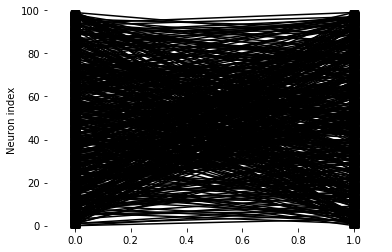

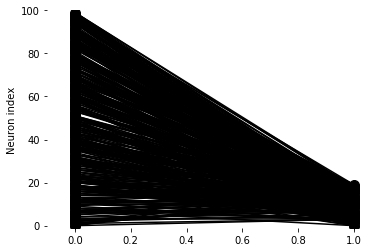

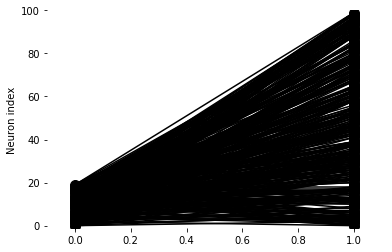

In [11]:
visualise_connectivity(Ce)
visualise_connectivity(Ce_i)
visualise_connectivity(Ci)

## Plotting example active neurons on the grid

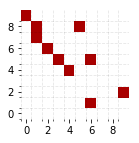

In [12]:
gridPlot(inp)

In [13]:
run(runtime * ms, report='text')
run(waittime * ms, report='text')

Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=100. ms for a duration of 1. s
1.0 (100%) simulated in 1s


WARNING    /usr/local/lib/python2.7/dist-packages/brian2/monitors/statemonitor.py:287: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(dtype, np.int):
 [py.warnings]
WARNING    /usr/local/lib/python2.7/dist-packages/brian2/monitors/statemonitor.py:57: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(dtype, np.int) and not isinstance(item, np.ndarray):
 [py.warnings]


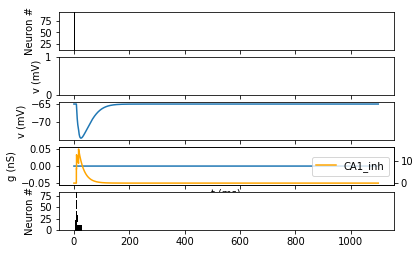

In [14]:
neuronIndex = 2
fig, ax = plt.subplots(nrows=5,sharex=True)
# ax.plot(trace.t/ms, trace.v/mV, label="CA3")
#raster_plot(inp)
for j in range(N_CA3):
    ax[0].plot(input_spikes.t/ms, input_spikes.i, '|k', label="CA3")
# frac_inh_active = 0
# for j in range(N_I):
#     if not np.sum(interneuron_volt[j].v-El) == 0:
#         ax[1].plot(interneuron_volt.t/ms, interneuron_volt[j].v/mV, label="I")
#         frac_inh_active+=1
# frac_inh_active/=float(N_I)
# print(frac_inh_active)
ax[2].plot(ca1_volt.t/ms, ca1_volt[neuronIndex].v/mV, label="CA1")
ax[3].plot(conductances.t/ms, conductances[neuronIndex].ge/nS, label="CA1_exc")
ax3_copy = ax[3].twinx()
ax3_copy.plot(conductances.t/ms, conductances[neuronIndex].gi/nS, color='orange', label="CA1_inh")
for j in range(N_CA1):
    ax[4].plot(output_spikes.t/ms, output_spikes.i, '|k', label="CA1")
# ax1 = fig.add_axes()
# ax1.plot(trace.t/ms, trace.i, c='b', label="CA3")

# ax[0].set_xlabel('t (ms)')
ax[0].set_ylabel('Neuron #')
# ax[1].set_xlabel('t (ms)')
ax[1].set_ylabel('v (mV)')
ax[2].set_ylabel('v (mV)')
ax[3].set_xlabel('t (ms)')
ax[3].set_ylabel('g (nS)')
ax[4].set_ylabel('Neuron #')
plt.legend(loc = 'center right')
plt.show()

## Giving repeated patterns 

In [15]:
numInputPatterns = 1
numRepeats = 100
for j in range(numInputPatterns):
    K = np.random.randint(1,20) # Number of neurons stimulated (based on fraction of area covered)
    inp = randomInput(N=N_CA3,K=K)
    
    active_indices = np.nonzero(inp)[0]
    input_time = 1*ms
    spike_times = K*[input_time]
    for k in range(numRepeats):
        Pe.set_spikes(active_indices, spike_times)
        run(runtime * ms, report='text')
        run(waittime * ms, report='text')
#     tuneSynapses()

Starting simulation at t=1.1 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=1.2 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=2.2 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=2.3 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=3.3 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=3.4 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=4.4 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=4.5 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=5.5 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=5.6 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=6.6 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=6.7 s for a duration of 1. s
1.0 (100%) simulated in 1

1.0 (100%) simulated in 1s
Starting simulation at t=55. s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=55.1 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=56.1 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=56.2 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=57.2 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=57.3 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=58.3 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=58.4 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=59.4 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=59.5 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=60.5 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=60.6 s for a dura

0.1 (100%) simulated in < 1s
Starting simulation at t=107.9 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=108.9 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=109. s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=110. s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=110.1 s for a duration of 1. s
1.0 (100%) simulated in 1s


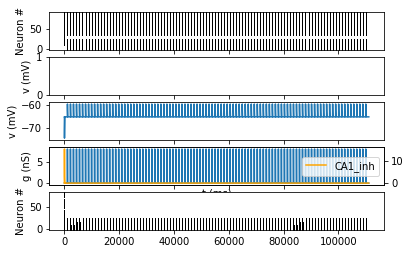

In [16]:
neuronIndex = 2
fig, ax = plt.subplots(nrows=5,sharex=True)
# ax.plot(trace.t/ms, trace.v/mV, label="CA3")
#raster_plot(inp)
for j in range(N_CA3):
    ax[0].plot(input_spikes.t/ms, input_spikes.i, '|k', label="CA3")
# frac_inh_active = 0
# for j in range(N_I):
#     if not np.sum(interneuron_volt[j].v-El) == 0:
#         ax[1].plot(interneuron_volt.t/ms, interneuron_volt[j].v/mV, label="I")
#         frac_inh_active+=1
# frac_inh_active/=float(N_I)
# print(frac_inh_active)
ax[2].plot(ca1_volt.t/ms, ca1_volt[neuronIndex].v/mV, label="CA1")
ax[3].plot(conductances.t/ms, conductances[neuronIndex].ge/nS, label="CA1_exc")
ax3_copy = ax[3].twinx()
ax3_copy.plot(conductances.t/ms, conductances[neuronIndex].gi/nS, color='orange', label="CA1_inh")
for j in range(N_CA1):
    ax[4].plot(output_spikes.t/ms, output_spikes.i, '|k', label="CA1")
# ax1 = fig.add_axes()
# ax1.plot(trace.t/ms, trace.i, c='b', label="CA3")

# ax[0].set_xlabel('t (ms)')
ax[0].set_ylabel('Neuron #')
# ax[1].set_xlabel('t (ms)')
ax[1].set_ylabel('v (mV)')
ax[2].set_ylabel('v (mV)')
ax[3].set_xlabel('t (ms)')
ax[3].set_ylabel('g (nS)')
ax[4].set_ylabel('Neuron #')
plt.legend(loc = 'center right')
plt.show()

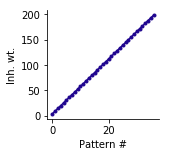

In [39]:
neuronIndices = np.arange(N_CA1)
step = len(conductances.t /ms)/51
ie_ratio = []
fig, ax = plt.subplots()
color_cell = matplotlib.cm.plasma(np.linspace(0,1,N_CA1))
for neuronIndex in neuronIndices[3:4]:
    for tslice in range(0,len(conductances.t /ms),step):
        currentRatio = np.max(conductances[neuronIndex].gi [tslice:tslice+step]/nS) / np.max(conductances[neuronIndex].ge [tslice:tslice+step]/nS)
        if 0 < currentRatio < 200:
            ie_ratio.append(currentRatio)
        else:
            ie_ratio.append(np.nan)
    ax.plot(ie_ratio, '.-', color=color_cell[neuronIndex])
simpleaxis(ax)
ax.set_xlabel("Pattern #")
ax.set_ylabel("Inh. wt.")
fig.set_figwidth(2)
fig.set_figheight(2)
plt.show()

## Giving multiple patterns 

In [15]:
numInputPatterns = 1
numRepeats = 100
for j in range(numInputPatterns):
    K = np.random.randint(1,20) # Number of neurons stimulated (based on fraction of area covered)
    inp = randomInput(N=N_CA3,K=K)
    
    active_indices = np.nonzero(inp)[0]
    input_time = 1*ms
    spike_times = K*[input_time]
    for k in range(numRepeats):
        Pe.set_spikes(active_indices, spike_times)
        run(runtime * ms, report='text')
        run(waittime * ms, report='text')
#     tuneSynapses()

Starting simulation at t=1.1 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=1.2 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=2.2 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=2.3 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=3.3 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=3.4 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=4.4 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=4.5 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=5.5 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=5.6 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=6.6 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=6.7 s for a duration of 1. s
1.0 (100%) simulated in 1

1.0 (100%) simulated in 1s
Starting simulation at t=55. s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=55.1 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=56.1 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=56.2 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=57.2 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=57.3 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=58.3 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=58.4 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=59.4 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=59.5 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=60.5 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=60.6 s for a dura

0.1 (100%) simulated in < 1s
Starting simulation at t=107.9 s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=108.9 s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=109. s for a duration of 1. s
1.0 (100%) simulated in 1s
Starting simulation at t=110. s for a duration of 100. ms
0.1 (100%) simulated in < 1s
Starting simulation at t=110.1 s for a duration of 1. s
1.0 (100%) simulated in 1s


In [18]:
conductances[neuronIndex].gi /nS [tslice:tslice+step]

IndexError: too many indices for array

## Tuning synapses

In [ ]:
numInputPatterns = 30
for j in range(numInputPatterns):
    K = np.random.randint(1,20) # Number of neurons stimulated (based on fraction of area covered)
    inp = randomInput(N=N_CA3,K=K)
    active_indices = np.nonzero(inp)[0]

    input_time = 1*ms
    spike_times = K*[input_time]
    Pe.set_spikes(active_indices, spike_times)
    run(runtime * ms, report='text')
    
    run(waittime * ms, report='text')